# GD01 ResNet Ablation Study  
## Objective  
###  ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?  
- 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.  

### 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?  
- tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.  

### Ablation Study 결과가 바른 포맷으로 제출되었는가?  
- ResNet-34, ResNet-50 각각 plain모델과 residual모델을  
동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### 1. 데이터셋 로드  
Cifar-10 을 사용합니다

In [2]:
import urllib3
urllib3.disable_warnings()

In [3]:

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train, ds_test, ds_val), ds_info = tfds.load('cats_vs_dogs', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], shuffle_files = True, with_info = True, as_supervised=True) #옵션을 주면 dict 형태가 아닌 tuple 형태로 데이터를 return 받습니다. 
#데이터셋명, 어떻게 나눌것인지, 파일 섞을것인지, 정보를 같이 불러올것인지 흠

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    t

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [6]:
# 갯수 확인하는 코드랍니다
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(13957, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)
tf.Tensor(4653, shape=(), dtype=int64)


In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

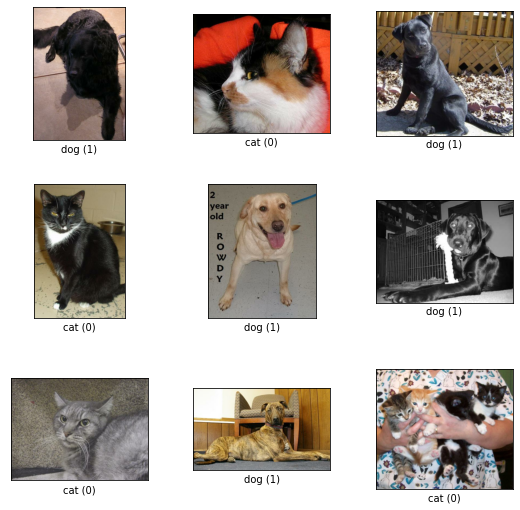

In [9]:
fig = tfds.show_examples(ds_train, ds_info)


### 2. 블록 구성하기   
반복적인 네트워크 구조를 '블록화' 하여 구현합니다  
주요 구조를 모듈화 시켜 하이퍼파라미터나 구조 변경시에 작업을 용이하게 진행할 수 있습니다

### VGG  
신경망의 깊이가 기존과 다르게 많이 깊어지기 시작한 모델 (2014)   

#### 구조  
입력 이미지 > (Conv 반복 + Maxpool) 반복  ----- FC -----> Softmax  


#### 블록 함수  
conv는 Vgg16의 경우 3, Vgg 19의 경우 4 (일부 초기/후기 2/3) 을 쓰는걸 확인할 수 있음  
괄호 안의 부분을 구현하게 됨  

In [10]:
#conv2D 원형 (filters. kernel size, strides, padding, activation, input shape) 등 파라메터는 아래를 참고해서 넣자  
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

#maxpool2D 원형(pool size, strides, padding, ) 등
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

def build_block_vgg(input_layer, num_cnn=3 , channel = 64, block_num = 1):
    
    x= input_layer
    
    #필터 수 = 채널 수
    #kernel_size는 VGG에서는 '매우 작다'라는 표현과 함게 3,3으로 고정하여 사용
    
    for cnn_num in range(num_cnn):    
        x = keras.layers.Conv2D(filters = channel, kernel_size = (3,3), activation = 'relu', 
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num}_conv{cnn_num}' )(x)

    x = keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name = f'block{block_num}_pooling')(x)    

    return x

In [11]:
#논문에 따르면 이후 레이어들은 공통으로 가짐
#이 부분 반복작업이라 함수로 하나 뺏지만, 변동이 없을 예정이라 별도의 파라미터는 label수만 받기로 해요

def build_tail_vgg(input_layer, output_num):
    #fully-connected 4096 4096 1000 소맥
    x = keras.layers.Flatten(name='flatten')(input_layer)
    x = keras.layers.Dense(4096, activation = 'relu', name = 'fc1')(x)
    x = keras.layers.Dense(4096, activation = 'relu', name = 'fc2')(x)
    x = keras.layers.Dense(output_num, activation = 'softmax', name = 'prediction')(x)
    return x

#### 초기화 및 모델 구성   
시작점 레이어 구성 후, 블록을 하나씩 붙여주게 됨

In [12]:
#parameters

num_labels = 10                          #라벨갯수
floors = [2,2,3,3,3]                     #반복층수 [2 2 3 3 3], 층마다 필터수(같음) [64 128 256 512 512] 
filters  = [64, 128, 256, 512, 512]      #채널이랑 같은말


In [13]:
#input으로 쓰는 경우가 정확히 어떤경우일까? 과거 ex들 보면 input을 따로 쓰지 않았던 경우도 존재했음 (예 : 5)
#https://smalldatalab.tistory.com/4 에 따르면 입력 데이터의 크기를 지정해주는 역할을 한다고는 하는데, 흠.. 꼭 필요할까요? 
#conv2D에서 입력수는 기존 레이어의 형태를 연결할때 자동으로 설정이 되긴 하는데ㅔㅔ, 처음에도 딱히 신경 안썼던거 같아서 ?

vgg_16_input_layer = keras.layers.Input(shape = (32,32,3))

#이런식으로 반복되려나
#vgg = for build_block_vgg(vgg_input_layer, channels, num_cnn (이거 변수명 floor로 바꾸고싶네), channel_list, 
#                          num_classes 이건 출력갯수)

In [14]:
#https://arxiv.org/pdf/1409.1556.pdf
#논문에서 소개된 단위


vgg_16_output_layer = vgg_16_input_layer

for i in range(5):     #이 숫자가 block_num이 될것이에요
    #num_cnn은 디폴트가 3이라 굳이 넣어줄 필요는 없음
    vgg_16_output_layer = build_block_vgg(vgg_16_output_layer, num_cnn = floors[i], channel = filters[i], block_num = i)

vgg_16_output_layer = build_tail_vgg(vgg_16_output_layer, num_labels)


In [15]:
vgg_16 = keras.Model(inputs=vgg_16_input_layer, outputs=vgg_16_output_layer)

In [16]:
vgg_16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0     

lms에서 실습했던 스팩과 동일한 model이 생성되었습니다

In [17]:
# mish / swish

### ResNet  
Skip connection을 적용하여, VGG 혹은 이후에 소개되는 모델들이 가지는 Degradation을 Skip connection으로 해결하는 시도를 제안한 모델  

#### 구조  
resnet 34는 2층씩, resnet 50은 3층씩 동일한 필터수와 차원을 가진 네트워크의 블록구조를 가집니다  
각 블록구조는 단계별로 3 / 4 / 6 / 3 번 반복됩니다  

블록 별 propagation은 conv > batchnorm > relu

In [18]:
#https://arxiv.org/pdf/1512.03385.pdf
#resnet 34는 2개 conv층 / 50은 3개 conv층, 풀링없음? 제일 마지막에 average pooling으로 정리


floor_iter = [3, 4, 6, 3]       #34, 50공통, 101 layers일때 [3, 4, 23, 3]
channels = [64, 128, 256, 612]


In [19]:
#def build_block_vgg(input_layer, num_cnn=3 , channel = 64, block_num = 1):
    
#    x= input_layer
    
    #필터 수 = 채널 수
    #kernel_size는 VGG에서는 '매우 작다'라는 표현과 함게 3,3으로 고정하여 사용
    
#    for cnn_num in range(num_cnn):    
#        x = keras.layers.Conv2D(filters = channel, kernel_size = (3,3), activation = 'relu', 
#                                kernel_initializer='he_normal', padding='same', name = f'block{block_num}_conv{cnn_num}' )(x)

#    x = keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, name = f'block{block_num}_pooling')(x)    

#    return x

In [20]:
def build_block_element_plain34(input_layer, channels, block_num, stage, first_block):     
    
    x = input_layer

    if(first_block):
        x = keras.layers.Conv2D(channels[block_num], kernel_size = (3,3) , strides=2,
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num+1}_conv{stage+1}_1' )(x)
    else:
        x = keras.layers.Conv2D(channels[block_num], kernel_size = (3,3) , 
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num+1}_conv{stage+1}_1' )(x)

    x = keras.layers.BatchNormalization(name=f'block{block_num+1}_0_bn{stage+1}_1')(x)
    x = keras.layers.Activation('relu', name=f'block{block_num+1}_0_relu{stage+1}_1')(x)

    x = keras.layers.Conv2D(channels[block_num], kernel_size = (3,3) ,
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num+1}_conv{stage+1}_2' )(x)            
    
    x = keras.layers.BatchNormalization(name=f'block{block_num+1}_0_bn{stage+1}_2')(x)
    x = keras.layers.Activation('relu', name=f'block{block_num+1}_0_relu{stage+1}_2')(x)
            
    
    return x

In [25]:
def build_block_element_res34(input_layer, channels, block_num, stage, first_block):     
    
    x = input_layer
    shortcut = x

    if(first_block):
        x = keras.layers.Conv2D(channels[block_num], kernel_size = (3,3) , strides=2,
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num+1}_conv{stage+1}_1' )(x)
    else:
        x = keras.layers.Conv2D(channels[block_num], kernel_size = (3,3) , 
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num+1}_conv{stage+1}_1' )(x)

    x = keras.layers.BatchNormalization(name=f'block{block_num+1}_0_bn{stage+1}_1')(x)
    x = keras.layers.Activation('relu', name=f'block{block_num+1}_0_relu{stage+1}_1')(x)

    x = keras.layers.Conv2D(channels[block_num], kernel_size = (3,3) ,
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num+1}_conv{stage+1}_2' )(x)            
    
    x = keras.layers.BatchNormalization(name=f'block{block_num+1}_0_bn{stage+1}_2')(x)
    
    try:
        nx= keras.layers.Add()([x, shortcut])
    except:
        shortcut = keras.layers.Conv2D(channels[block_num], kernel_size = (3,3) , strides=2, padding='same')(shortcut)
        nx= keras.layers.Add()([x, shortcut])
    
    x = keras.layers.Activation('relu', name=f'block{block_num+1}_0_relu{stage+1}_2')(nx)
            
    
    return x

In [22]:
num_classes = 2

def build_plain34():     
    
    
    input_layer = keras.layers.Input(shape = (224,224,3))    
    output_layer = input_layer  
    
    
    output_layer= keras.layers.Conv2D(filters=64, kernel_size=(7,7), 
                                      kernel_initializer='he_normal', padding='same', strides=2)(output_layer)
    output_layer= keras.layers.BatchNormalization()(output_layer)
    output_layer= keras.layers.Activation('relu')(output_layer)
    output_layer= keras.layers.MaxPooling2D(pool_size= (2,2), strides=2)(output_layer)    
    
    for i in range(len(floor_iter)):
        for j in range(floor_iter[i]):
            output_layer = build_block_element_plain34(output_layer, channels, i, j, j==0)
            
      
    output_layer = keras.layers.AveragePooling2D()(output_layer)
    output_layer = keras.layers.Flatten(name='flatten')(output_layer)
    output_layer = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output_layer)
    
    x= keras.Model(inputs=input_layer, outputs=output_layer)
    return x


In [23]:
num_classes = 2

def build_resnet34():     
    
    
    input_layer = keras.layers.Input(shape = (224,224,3))    
    output_layer = input_layer  
    
    
    output_layer= keras.layers.Conv2D(filters=64, kernel_size=(7,7), 
                                      kernel_initializer='he_normal', padding='same', strides=2)(output_layer)
    output_layer= keras.layers.BatchNormalization()(output_layer)
    output_layer= keras.layers.Activation('relu')(output_layer)
    output_layer= keras.layers.MaxPooling2D(pool_size= (2,2), strides=2)(output_layer)    
    
    for i in range(len(floor_iter)):
        for j in range(floor_iter[i]):
            output_layer = build_block_element_res34(output_layer, channels, i, j, j==0)
            
      
    output_layer = keras.layers.AveragePooling2D()(output_layer)
    output_layer = keras.layers.Flatten(name='flatten')(output_layer)
    output_layer = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output_layer)
    
    x= keras.Model(inputs=input_layer, outputs=output_layer)
    return x


In [26]:
res34 = build_resnet34()

In [27]:
res34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [28]:
plain34 = build_plain34()

In [29]:
plain34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block1_conv1_1 (Conv2D)      (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_0_bn1_1 (BatchNormali (None, 28, 28, 64)        256 

In [ ]:
def build_block_element_plain50(input_layer, channels, stage, block_num):     #stage 몇번째 단계인가
    
    x = input_layer

    x = keras.layers.conv2D(channels[stage], kernel_size = (1,1) ,activation = 'relu', 
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num}_conv1' )(x)
    x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
    x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)

    x = keras.layers.conv2D(channels[stage], kernel_size = (3,3) ,activation = 'relu', 
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num}_conv2' )(x)
    x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
    x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)
        
        
    x = keras.layers.conv2D(channels[stage]*4, kernel_size = (1,1) ,activation = 'relu', 
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num}_conv3' )(x)
    x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
    x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)
                
    return x

In [ ]:
def build_block_element_res50(input_layer, channels, floor_iter, block_num):
    
    x = input_layer
    for i in range(floor_iter):
        
        x = keras.layers.conv2D(channels[i], kernel_size = (3,3) ,activation = 'relu', 
                                kernel_initializer='he_normal', padding='same', name = f'block{block_num}_conv{cnn_num}' )(x)

In [ ]:

        


        

        


        


    
        
    #여기서 x를 그대로 반환 / x+ input layer를 반환하는 분기점이 생기는 건지?
    #그냥 +로 합치는 건지

def build_block_res(input_layer, channels, floor_iter, ):
    
    x= input_layer
    for i in range

In [ ]:
def build_resnet(input_shape=(32, 32,3), is_50=False):
    
    model = keras.layers.Input(shape = input_shape)
    
    if is_50 is true:
        
        model = build_resnet_50(input_shape, model)
    
    else:
        model = build_resnet_34(input_shape, model)
        
    return model
    
    

In [ ]:
def build_resnet_34(input_shape, model):
    

In [ ]:
def build_resnet_50(input_shape, model):
    

In [ ]:
#resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
#resnet_34.summary()

In [ ]:
#https://github.com/mlhy/ResNet-50-for-Cats.Vs.Dogs/blob/master/ResNet-50%20for%20Cats.Vs.Dogs..ipynb